<a href="https://colab.research.google.com/github/ZichangYe/NBA-Analytics/blob/master/Q2_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports 

In [10]:
import torch 
import torchvision
import torch.nn as nn
import torch.nn.functional as F 
from IPython.display import Image 
from torchvision import transforms
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import datetime
today_date = datetime.datetime.today()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed = 12345
random.seed(seed)
torch.manual_seed(seed)

#### Mount your google drive so you can save model checkpoints, and report your test results on the final best model after hyperparameter tuning

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Data loading 

##### Run the following cells to load the dataset. Setting download=True will download it for you.

In [12]:
cifar10_train = torchvision.datasets.CIFAR10(root='./cifar10', 
                                             train=True, 
                                             transform=None, 
                                             target_transform=None,
                                             download=True)
cifar10_test = torchvision.datasets.CIFAR10(root='./cifar10', 
                                             train=False, 
                                             transform=None, 
                                             target_transform=None,
                                             download=True)

# Divides the dataset into train and val so that we can use the val to choose our hyperparameters
train_dataset, val_dataset = torch.utils.data.random_split(cifar10_train, [40000, 10000], 
                                                           generator=torch.Generator().manual_seed(12345))
test_dataset = cifar10_test

Files already downloaded and verified
Files already downloaded and verified


In [13]:
# Helper code to support adding different transforms on the dataset lazily after downloading the dataset
# From https://discuss.pytorch.org/t/apply-different-transform-data-augmentation-to-train-and-validation/63580/5
class MapDataset(torch.utils.data.Dataset):
    """
    Given a dataset, creates a dataset which applies a mapping function
    to its items (lazily, only when an item is called).

    Note that data is not cloned/copied from the initial dataset.
    """

    def __init__(self, dataset, map_fn):
        self.dataset = dataset
        self.map = map_fn

    def __getitem__(self, index):
        if self.map:     
            x = self.map(self.dataset[index][0]) 
        else:     
            x = self.dataset[index][0]  
        y = self.dataset[index][1]         
        return x, y

    def __len__(self):
        return len(self.dataset)

#### Standard transforms to apply on images - Convert to tensors and normalize with mean and std. These are the basic transforms that you will always apply. The mean and std have been pre calculated on the training set. 

In [14]:
# Notice that we apply the same mean and std normalization calculated on train, to both the train and test datasets.
test_transform = transforms.Compose([
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         [0.4373, 0.4434, 0.4725],
                                         [0.1201, 0.1231, 0.1052])
                                     ])

train_transform = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize(
                                          [0.4373, 0.4434, 0.4725],
                                          [0.1201, 0.1231, 0.1052])
                                      ])


In [15]:
train_dataset_w_transform  = MapDataset(train_dataset, train_transform)
val_dataset_w_transform = MapDataset(val_dataset, test_transform)
test_dataset_w_transform = MapDataset(test_dataset, test_transform)

In [16]:
bs = 128
torch.backends.cudnn.benchmark = True
train_loader = DataLoader(train_dataset_w_transform, batch_size=bs, shuffle=True, drop_last=False,num_workers=10, pin_memory=True)
val_loader = DataLoader(val_dataset_w_transform, batch_size=bs, shuffle=False, drop_last=False,num_workers=10, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False, drop_last=False,num_workers=10, pin_memory=True)

### Q 2.1 Training loop

In this question, fill in the missing parts to build a generic training loop that returns the train and validation losses and accuracies. The #TODOs will guide you through the key points and you should fill some code for each #TODO. You might need to add some additional code for bookkeeping the losses and accuracies

In [17]:
def train_loop(model, criterion, optimizer,  train_loader, val_loader):
    """
    Generic training loop

    Parameters
    ----------
    model : Object instance of your model class 
    criterion : Loss function 
    optimizer : Instance of optimizer class of your choice 
    train_loader : Training data loader 
    val_loader : Validation data loader

    Returns
    -------
    train_losses : List with train loss on dataset per epoch
    train_accuracies : List with train accuracy on dataset per epoch
    val_losses : List with validation loss on dataset per epoch
    val_accuracies : List with validation accuracy on dataset per epoch

    """
    best_val = 0.0
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    max_patience = 5
    patience_counter = 0
    # Training
    for t in tqdm(range(50)):
        # TODO : Set the model to train mode        
        model.train()
        train_correct = 0
        val_correct = 0
        # TODO: Loop over the training set 
        for batch_idx, (data, target) in enumerate(train_loader):
            # TODO: Put the inputs and targets on the write device
            data, target = data.to(device), target.to(device)
            # TODO: Feed forward to get the logits
            output = model(data)
            # TODO: Compute the loss and accuracy
            train_loss = criterion(output, target)
            train_pred = output.data.max(1, keepdim=True)[1]
            train_correct += train_pred.eq(target.data.view_as(train_pred)).cpu().sum().item()
            train_accuracy = 100. * train_correct/len(train_loader.dataset)
            # print('Training Accuracy: {}'.format(train_accuracy))
            # TODO: zero the gradients before running
            optimizer.zero_grad()
            # the backward pass.
            
            # TODO: Backward pass to compute the gradient
            # of loss w.r.t our learnable params. 
            train_loss.backward()
            # TODO: Update params
            optimizer.step()
            # TODO: Keep track of accuracy and loss
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        # TODO: Switch the model to eval mode
        model.eval()

        with torch.no_grad():
            # TODO: Loop over the validation set 
            for batch_idx, (data, target) in enumerate(val_loader):
                # TODO: Put the inputs and targets on the write device
                data, target = data.to(device), target.to(device)
                # TODO: Feed forward to get the logits
                output = model(data)
                # TODO: Compute the loss and accuracy
                val_loss = criterion(output, target)
                val_pred = output.data.max(1, keepdim=True)[1]
                val_correct += val_pred.eq(target.data.view_as(val_pred)).cpu().sum().item()
                val_accuracy = 100. * val_correct/len(val_loader.dataset)
                # print('Validation Accuracy: {}'.format(val_accuracy))
     
                # TODO: Keep track of accuracy and loss
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)              
        if val_accuracies[-1] > best_val:
          best_val = val_accuracies[-1]
          patience_counter = 0

          # TODO: Save best model, optimizer, epoch_number
          best_model = model
          best_optimizer = optimizer
          best_epoch_number = t
        else:
          patience_counter += 1    
          if patience_counter > max_patience: 
            break

        print("[EPOCH]: %i, [TRAIN LOSS]: %.6f, [TRAIN ACCURACY]: %.3f" % (t, train_losses[-1], train_accuracies[-1]))
        print("[EPOCH]: %i, [VAL LOSS]: %.6f, [VAL ACCURACY]: %.3f \n" % (t, val_losses[-1] ,val_accuracies[-1]))

    return train_losses, train_accuracies, val_losses, val_accuracies

In [18]:
def save_model(model_name, model, train_losses, train_accuracies, val_losses, val_accuracies):
  with open('/content/drive/My Drive/{}_{}.txt'.format(model_name, today_date), 'w') as writefile:
    writefile.write("train_accuracies: \n")
    writefile.writelines(str(accuracy) +', \n' for accuracy in train_accuracies)
    writefile.write('\n')
    writefile.write("train_losses: \n")
    writefile.writelines(str(loss) +', \n' for loss in train_losses)
    writefile.write('\n')
    writefile.write("val_accuracies: \n")
    writefile.writelines(str(accuracy) +', \n' for accuracy in val_accuracies)
    writefile.write('\n')
    writefile.write("val_losses: \n")
    writefile.writelines(str(loss) +', \n' for loss in val_losses)
    writefile.write('\n')

  # save models
  model_save_name = 'model_{}_{}.pt'.format(model_name,today_date)
  path = F"/content/drive/My Drive/{model_save_name}" 
  torch.save(model.state_dict(), path)
  
  return None

### Q 2.2 Shallow convolutional network. 

In [19]:
class View(nn.Module):
    def __init__(self, shape):
      super().__init__()
      self.shape = shape

    def forward(self, x):
        return x.view(*self.shape)

In [20]:
ShallowNet =  nn.Sequential(
      nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size=5, padding=2),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2),
      nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2),
      nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=8),
      View((-1,256)),
      nn.Linear(256, 10),
)

#### Write the object oriented version of ShallowNet

In [ ]:
class ShallowConvnet(nn.Module):
    def __init__(self, input_channels, num_classes):
        """

        Parameters
        ----------
        input_channels : Number of input channels
        num_classes : Number of classes for the final prediction 
        """
        super(ShallowConvnet, self).__init__()
        self.input_channels = input_channels
        # TODO
        self.network = nn.Sequential(
            nn.Conv2d(in_channels = input_channels, out_channels = 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=8),
            View((-1,256)),
            nn.Linear(256, num_classes),
      )
        

    def forward(self, x):
        """

        Parameters
        ----------
        x

        Returns
        -------
        output : Result after running through the model
        """
        # TODO
        # x = x.view(-1, self.input_channels)?
        return self.network(x)
        

### Q2.3 Instantiate the model and run this using an SGD optimizer, with the appropriate loss function for classification

Report the learning curves (training and validation accuracy vs number of epochs)

In [ ]:
# TODO : Initialize the model and cast to correct device
model_ShallowConv = ShallowConvnet(input_channels = 3, num_classes = 10)
model_ShallowConv.to(device)

# TODO : Initialize the criterion
criterion = F.cross_entropy

# TODO : Initialize the SGD optimizer with lr 1e-3
optimizer = optim.SGD(model_ShallowConv.parameters(), lr=1e-3, momentum=0.5)

# TODO : Run the training loop using this model
train_losses, train_accuracies, val_losses, val_accuracies = train_loop(model_ShallowConv, criterion, optimizer, train_loader, val_loader)


[EPOCH]: 25, [TRAIN LOSS]: 1.216962, [TRAIN ACCURACY]: 56.877
[EPOCH]: 25, [VAL LOSS]: 0.877081, [VAL ACCURACY]: 54.800 

[EPOCH]: 26, [TRAIN LOSS]: 1.082827, [TRAIN ACCURACY]: 57.388
[EPOCH]: 26, [VAL LOSS]: 0.875490, [VAL ACCURACY]: 55.870 

[EPOCH]: 27, [TRAIN LOSS]: 1.339500, [TRAIN ACCURACY]: 57.775
[EPOCH]: 27, [VAL LOSS]: 0.928765, [VAL ACCURACY]: 55.990 

[EPOCH]: 28, [TRAIN LOSS]: 1.290953, [TRAIN ACCURACY]: 58.528
[EPOCH]: 28, [VAL LOSS]: 0.749431, [VAL ACCURACY]: 56.790 

[EPOCH]: 29, [TRAIN LOSS]: 1.245437, [TRAIN ACCURACY]: 59.110
[EPOCH]: 29, [VAL LOSS]: 0.870463, [VAL ACCURACY]: 56.180 

[EPOCH]: 30, [TRAIN LOSS]: 1.349535, [TRAIN ACCURACY]: 59.547
[EPOCH]: 30, [VAL LOSS]: 0.757730, [VAL ACCURACY]: 57.400 

[EPOCH]: 31, [TRAIN LOSS]: 0.963689, [TRAIN ACCURACY]: 59.925
[EPOCH]: 31, [VAL LOSS]: 0.813436, [VAL ACCURACY]: 58.320 

[EPOCH]: 32, [TRAIN LOSS]: 1.108154, [TRAIN ACCURACY]: 60.455
[EPOCH]: 32, [VAL LOSS]: 0.819942, [VAL ACCURACY]: 56.210 

[EPOCH]: 33, [TRAIN LOSS

In [ ]:
with open('/content/drive/My Drive/model_ShallowConv_{}.txt'.format(today_date), 'w') as writefile:
    writefile.write("train_accuracies: \n")
    writefile.writelines(str(accuracy) +', \n' for accuracy in train_accuracies)
    writefile.write('\n')
    writefile.write("val_accuracies: \n")
    writefile.writelines(str(accuracy) for accuracy in val_accuracies)
    writefile.write('\n')

In [ ]:
# save models
model_save_name = 'model_ShallowConv_{}.pt'.format(today_date)
path = F"/content/drive/My Drive/{model_save_name}" 
torch.save(model_ShallowConv.state_dict(), path)

Text(0.5, 1.0, 'Training &Validation Learning Rate')

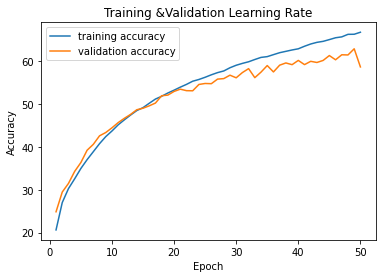

In [ ]:
# visualize learning rate
plt.plot(np.arange(1, len(train_accuracies)+1), train_accuracies, label='training accuracy')
plt.plot(np.arange(1, len(val_accuracies)+1), val_accuracies, label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Learning Rate')

### Q2.4 Simple convolution network - 

Design a convolutional neural network with the following specification: 
For each convolution layer, use appropriate padding such that it maintains the resolution of the image. The resolution should be changing only when you introduce maxpooling layers. Each convolution layer should be followed by a relu non-linearity. The first two blocks containing 3 convolutional layers are each followed by a maxpooling layer that halves the resolution of the image. After the third block, use maxpooling to get a resolution of 1 X 1. Finally, apply a linear transformation to project to the number of classes. 

Structure of the convolution layers of the model:
1. Number of input channels to the model = 3
2. First convolution layer of kernel size 5 with filter size 64 and padding such that it maintains the resolution of the image.
3. Followed by a block of 3 convolution layers of kernel size 3, filter size 64 and padding such that it maintains the resolution of the image.
5. Followed by 3 convolution layers of kernel size 3, filter size 128 and padding such that it maintains the resolution of the image.
6. Followed by 3 convolution layers of kernel size 3, filter size 256 and padding such that it maintains the resolution of the image. 




In [13]:
# Use the description of the structure of the model and the hints given below 

class SimpleConvnet(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(SimpleConvnet, self).__init__()
        
        # TODO
        self.network = nn.Sequential(
            # first layer, resolution = 32
            nn.Conv2d(input_channels, out_channels=64, kernel_size=5, padding=2),
            nn.ReLU(),
            # first block, resolution = 32
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),

            # first maxpooling, resolution = 16
            nn.MaxPool2d(kernel_size=2,stride=2),

            # second block, resolution = 32
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=9),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),

            # second maxpooling, resolution = 16
            nn.MaxPool2d(kernel_size=2, stride=2),

            # # third block, resolution = 32
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=9),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),

            # final maxpooling, output size reduced to 1
            nn.MaxPool2d(kernel_size=32),
            View((-1,256)),
            nn.Linear(256, num_classes)
      )
    
    def forward(self, x):
       
        # TODO 
        output = self.network(x)
        return output
        

In [ ]:
# TODO : Initialize the model and cast to correct device
model_SimpleConv = SimpleConvnet(input_channels=3, num_classes=10)
model_SimpleConv.to(device)

# TODO : Initialize the criterion 
criterion = F.cross_entropy
# TODO : Initialize the optimizer 
optimizer = optim.SGD(model_SimpleConv.parameters(), lr=1e-3, momentum=0.5)
# TODO : Run the training loop using this model
train_losses_SimpleConv, train_accuracies_SimpleConv, val_losses_SimpleConv, val_accuracies_SimpleConv = train_loop(model_SimpleConv, criterion, optimizer, train_loader, val_loader)


[EPOCH]: 0, [TRAIN LOSS]: 2.296185, [TRAIN ACCURACY]: 9.977
[EPOCH]: 0, [VAL LOSS]: 2.300525, [VAL ACCURACY]: 10.090 

[EPOCH]: 1, [TRAIN LOSS]: 2.303188, [TRAIN ACCURACY]: 9.977
[EPOCH]: 1, [VAL LOSS]: 2.300627, [VAL ACCURACY]: 10.090 

[EPOCH]: 2, [TRAIN LOSS]: 2.306332, [TRAIN ACCURACY]: 9.977
[EPOCH]: 2, [VAL LOSS]: 2.300708, [VAL ACCURACY]: 10.090 

[EPOCH]: 3, [TRAIN LOSS]: 2.298346, [TRAIN ACCURACY]: 9.977
[EPOCH]: 3, [VAL LOSS]: 2.300823, [VAL ACCURACY]: 10.090 

[EPOCH]: 4, [TRAIN LOSS]: 2.298872, [TRAIN ACCURACY]: 9.977
[EPOCH]: 4, [VAL LOSS]: 2.300929, [VAL ACCURACY]: 10.090 

[EPOCH]: 5, [TRAIN LOSS]: 2.304439, [TRAIN ACCURACY]: 9.977
[EPOCH]: 5, [VAL LOSS]: 2.301031, [VAL ACCURACY]: 10.090 



In [ ]:

with open('/content/drive/My Drive/model_SimpleConvnet_{}.txt'.format(today_date), 'w') as writefile:
    writefile.write("train_accuracies: \n")
    writefile.writelines(str(accuracy) +', \n' for accuracy in train_accuracies_SimpleConv)
    writefile.write('\n')
    writefile.write("val_accuracies: \n")
    writefile.writelines(str(accuracy) +', \n' for accuracy in val_accuracies_SimpleConv)
    writefile.write('\n')

# save models
model_save_name = 'model_SimpleConv_{}.pt'.format(today_date)
path = F"/content/drive/My Drive/{model_save_name}" 
torch.save(model_SimpleConv.state_dict(), path)

Text(0.5, 1.0, 'Training for SimpleConvnet')

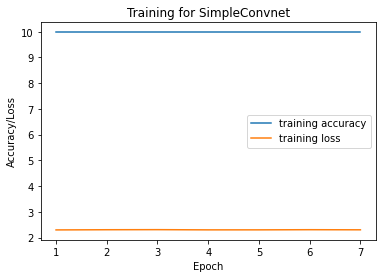

In [ ]:
plt.plot(np.arange(1, len(train_accuracies_SimpleConv)+1), train_accuracies_SimpleConv, label='training accuracy')
plt.plot(np.arange(1, len(train_losses_SimpleConv)+1), train_losses_SimpleConv, label='training loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy/Loss')
plt.legend()
plt.title('Training for SimpleConvnet')

### Q 2.5 Report results of training using SGD optimizer for both ShallowNet and SimpleConvnet. What do you observe?

The ShallowNet does learn, while the SimpleConvnet didn't learn using this architecture, which stopped after 6 epochs because of not learning.

### Q 2.6 Add batch normalization

#### Q2.6 a After each relu layer, add a batch normalization layer to the network SimpleConvnet you created above

In [ ]:
class SimpleConvnet2(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(SimpleConvnet2, self).__init__()
        
        # TODO
        self.network = nn.Sequential(
            # first layer, resolution = 32
            nn.Conv2d(input_channels, out_channels=64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            # first block, resolution = 32
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),

            # first maxpooling, resolution = 16
            nn.MaxPool2d(kernel_size=2,stride=2),

            # second block, resolution = 32
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=9),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),

            # second maxpooling, resolution = 16
            nn.MaxPool2d(kernel_size=2, stride=2),

            # # third block, resolution = 32
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=9),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),

            # final maxpooling, output size reduced to 1
            nn.MaxPool2d(kernel_size=32),
            View((-1,256)),
            nn.Linear(256, num_classes)
      )
    def forward(self, x):
       
       # TODO
        output = self.network(x)
        return output
        

In [ ]:
model_SimpleConv2 = SimpleConvnet2(input_channels=3, num_classes=10)
model_SimpleConv2.to(device)

# TODO : Initialize the criterion 
criterion = F.cross_entropy
# TODO : Initialize the optimizer 
optimizer = optim.SGD(model_SimpleConv2.parameters(), lr=1e-3, momentum=0.5)
# TODO : Run the training loop using this model
train_losses_SimpleConv2, train_accuracies_SimpleConv2, val_losses_SimpleConv2, val_accuracies_SimpleConv2 = train_loop(model_SimpleConv2, criterion, optimizer, train_loader, val_loader)


[EPOCH]: 12, [TRAIN LOSS]: 0.138822, [TRAIN ACCURACY]: 96.168
[EPOCH]: 12, [VAL LOSS]: 0.953608, [VAL ACCURACY]: 67.050 

[EPOCH]: 13, [TRAIN LOSS]: 0.096698, [TRAIN ACCURACY]: 98.062
[EPOCH]: 13, [VAL LOSS]: 1.069855, [VAL ACCURACY]: 67.810 

[EPOCH]: 14, [TRAIN LOSS]: 0.012484, [TRAIN ACCURACY]: 99.325
[EPOCH]: 14, [VAL LOSS]: 1.401978, [VAL ACCURACY]: 68.240 

[EPOCH]: 15, [TRAIN LOSS]: 0.015249, [TRAIN ACCURACY]: 99.828
[EPOCH]: 15, [VAL LOSS]: 1.124377, [VAL ACCURACY]: 68.970 

[EPOCH]: 16, [TRAIN LOSS]: 0.004704, [TRAIN ACCURACY]: 99.985
[EPOCH]: 16, [VAL LOSS]: 1.227966, [VAL ACCURACY]: 69.430 

[EPOCH]: 17, [TRAIN LOSS]: 0.004896, [TRAIN ACCURACY]: 99.995
[EPOCH]: 17, [VAL LOSS]: 1.360779, [VAL ACCURACY]: 69.390 

[EPOCH]: 18, [TRAIN LOSS]: 0.013475, [TRAIN ACCURACY]: 99.998
[EPOCH]: 18, [VAL LOSS]: 1.395045, [VAL ACCURACY]: 69.460 

[EPOCH]: 19, [TRAIN LOSS]: 0.001887, [TRAIN ACCURACY]: 100.000
[EPOCH]: 19, [VAL LOSS]: 1.328384, [VAL ACCURACY]: 69.490 

[EPOCH]: 20, [TRAIN LOS

#### Q2.6 b Plot the the training curves (training loss vs \# epochs, training accuracy vs # epochs) using SGD (lr 1e-3) with and without batch normalization. Comment on the difference. 




As the plots shown below, the SimpleConvnet with batch normalization learns and actually is able to satuate to accuracy 100% on the training set, while the SimpleConvnet without batch normalization did not learn and stop training.

In [ ]:
with open('/content/drive/My Drive/model_SimpleConvnet2_{}.txt'.format(today_date), 'w') as writefile:
    writefile.write("train_accuracies: \n")
    writefile.writelines(str(accuracy) +', \n' for accuracy in train_accuracies_SimpleConv2)
    writefile.write('\n')
    writefile.write("val_accuracies: \n")
    writefile.writelines(str(accuracy) +', \n' for accuracy in val_accuracies_SimpleConv2)
    writefile.write('\n')

# save models
model_save_name = 'model_SimpleConv2_{}.pt'.format(today_date)
path = F"/content/drive/My Drive/{model_save_name}" 
torch.save(model_SimpleConv2.state_dict(), path)

Text(0.5, 1.0, 'Training for SimpleConvnet with Batch Normalization')

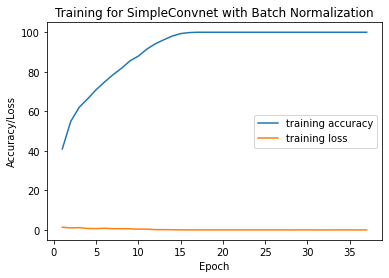

In [ ]:
# with Batch Normalization
# plot training loss vs epochs, training accuracy vs. epochs
plt.plot(np.arange(1, len(train_accuracies_SimpleConv2)+1), train_accuracies_SimpleConv2, label='training accuracy')
plt.plot(np.arange(1, len(train_losses_SimpleConv2)+1), train_losses_SimpleConv2, label='training loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy/Loss')
plt.legend()
plt.title('Training for SimpleConvnet with Batch Normalization')

Text(0.5, 1.0, 'Training for SimpleConvnet')

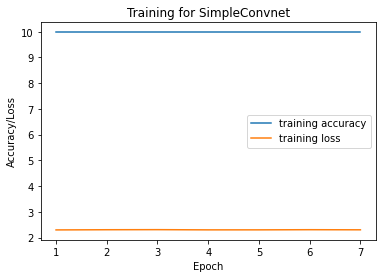

In [ ]:
# without Batch Normalization
plt.plot(np.arange(1, len(train_accuracies_SimpleConv)+1), train_accuracies_SimpleConv, label='training accuracy')
plt.plot(np.arange(1, len(train_losses_SimpleConv)+1), train_losses_SimpleConv, label='training loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy/Loss')
plt.legend()
plt.title('Training for SimpleConvnet')

#### Q2.6 c. Try running the same two networks with an Adam optimizer (lr 1e-4). Plot the the training curves (training loss vs \# epochs, training accuracy vs # epochs) with and without batch normalization. Comment on the difference. 

In [ ]:
# with normalization
model_SimpleConv2_adam = SimpleConvnet2(input_channels=3, num_classes=10)
model_SimpleConv2_adam.to(device)

# TODO : Initialize the criterion 
criterion = F.cross_entropy
# TODO : Initialize the optimizer 
optimizer = optim.Adam(model_SimpleConv2_adam.parameters(), lr=1e-4)
# TODO : Run the training loop using this model
train_losses_SimpleConv2_adam, train_accuracies_SimpleConv2_adam, \
  val_losses_SimpleConv2_adam, val_accuracies_SimpleConv2_adam = train_loop(model_SimpleConv2_adam, 
                                                                            criterion, optimizer, 
                                                                            train_loader, val_loader)


[EPOCH]: 0, [TRAIN LOSS]: 1.293137, [TRAIN ACCURACY]: 44.385
[EPOCH]: 0, [VAL LOSS]: 1.010047, [VAL ACCURACY]: 54.020 

[EPOCH]: 1, [TRAIN LOSS]: 1.078448, [TRAIN ACCURACY]: 60.053
[EPOCH]: 1, [VAL LOSS]: 0.775147, [VAL ACCURACY]: 62.050 

[EPOCH]: 2, [TRAIN LOSS]: 0.942608, [TRAIN ACCURACY]: 67.265
[EPOCH]: 2, [VAL LOSS]: 0.661924, [VAL ACCURACY]: 66.680 

[EPOCH]: 3, [TRAIN LOSS]: 0.773756, [TRAIN ACCURACY]: 72.795
[EPOCH]: 3, [VAL LOSS]: 0.774370, [VAL ACCURACY]: 68.640 

[EPOCH]: 4, [TRAIN LOSS]: 0.591982, [TRAIN ACCURACY]: 77.480
[EPOCH]: 4, [VAL LOSS]: 0.665500, [VAL ACCURACY]: 70.720 

[EPOCH]: 5, [TRAIN LOSS]: 0.534567, [TRAIN ACCURACY]: 81.927
[EPOCH]: 5, [VAL LOSS]: 0.645053, [VAL ACCURACY]: 71.540 

[EPOCH]: 6, [TRAIN LOSS]: 0.592124, [TRAIN ACCURACY]: 85.165
[EPOCH]: 6, [VAL LOSS]: 0.744968, [VAL ACCURACY]: 72.040 

[EPOCH]: 7, [TRAIN LOSS]: 0.477070, [TRAIN ACCURACY]: 88.925
[EPOCH]: 7, [VAL LOSS]: 0.470928, [VAL ACCURACY]: 73.010 

[EPOCH]: 8, [TRAIN LOSS]: 0.269564, [TRA

In [ ]:
def save_model(model_name, model, train_losses, train_accuracies, val_losses, val_accuracies):
  with open('/content/drive/My Drive/{}_{}.txt'.format(model_name, today_date), 'w') as writefile:
    writefile.write("train_accuracies: \n")
    writefile.writelines(str(accuracy) +', \n' for accuracy in train_accuracies)
    writefile.write('\n')
    writefile.write("train_losses: \n")
    writefile.writelines(str(loss) +', \n' for loss in train_losses)
    writefile.write('\n')
    writefile.write("val_accuracies: \n")
    writefile.writelines(str(accuracy) +', \n' for accuracy in val_accuracies)
    writefile.write('\n')
    writefile.write("val_losses: \n")
    writefile.writelines(str(loss) +', \n' for loss in val_losses)
    writefile.write('\n')

  # save models
  model_save_name = 'model_{}_{}.pt'.format(model_name,today_date)
  path = F"/content/drive/My Drive/{model_save_name}" 
  torch.save(model.state_dict(), path)
  
  return None

In [ ]:
# without normalization
model_SimpleConv_adam = SimpleConvnet(input_channels=3, num_classes=10)
model_SimpleConv_adam.to(device)

# TODO : Initialize the criterion 
criterion = F.cross_entropy
# TODO : Initialize the optimizer 
optimizer = optim.Adam(model_SimpleConv_adam.parameters(), lr=1e-4)
# TODO : Run the training loop using this model
train_losses_SimpleConv_adam, train_accuracies_SimpleConv_adam, \
  val_losses_SimpleConv_adam, val_accuracies_SimpleConv_adam = train_loop(model_SimpleConv_adam, 
                                                                          criterion, optimizer, 
                                                                          train_loader, val_loader)

[EPOCH]: 0, [TRAIN LOSS]: 1.653339, [TRAIN ACCURACY]: 25.505
[EPOCH]: 0, [VAL LOSS]: 1.722109, [VAL ACCURACY]: 35.050 

[EPOCH]: 1, [TRAIN LOSS]: 1.349501, [TRAIN ACCURACY]: 40.737
[EPOCH]: 1, [VAL LOSS]: 1.287937, [VAL ACCURACY]: 45.510 

[EPOCH]: 2, [TRAIN LOSS]: 1.525664, [TRAIN ACCURACY]: 47.350
[EPOCH]: 2, [VAL LOSS]: 1.055555, [VAL ACCURACY]: 47.370 

[EPOCH]: 3, [TRAIN LOSS]: 1.228956, [TRAIN ACCURACY]: 51.542
[EPOCH]: 3, [VAL LOSS]: 1.025691, [VAL ACCURACY]: 53.480 

[EPOCH]: 4, [TRAIN LOSS]: 1.027877, [TRAIN ACCURACY]: 55.278
[EPOCH]: 4, [VAL LOSS]: 1.054157, [VAL ACCURACY]: 55.790 

[EPOCH]: 5, [TRAIN LOSS]: 1.221658, [TRAIN ACCURACY]: 58.680
[EPOCH]: 5, [VAL LOSS]: 1.153800, [VAL ACCURACY]: 56.530 

[EPOCH]: 6, [TRAIN LOSS]: 1.250584, [TRAIN ACCURACY]: 61.655
[EPOCH]: 6, [VAL LOSS]: 1.156124, [VAL ACCURACY]: 59.360 

[EPOCH]: 7, [TRAIN LOSS]: 0.897822, [TRAIN ACCURACY]: 63.987
[EPOCH]: 7, [VAL LOSS]: 1.012385, [VAL ACCURACY]: 62.960 

[EPOCH]: 8, [TRAIN LOSS]: 1.065568, [TRA

In [ ]:

save_model(model_name = 'SimpleConv_adam', 
           model = model_SimpleConv_adam, 
           train_losses = train_losses_SimpleConv_adam,
           train_accuracies = train_accuracies_SimpleConv_adam,
           val_losses = val_losses_SimpleConv_adam,
           val_accuracies = val_accuracies_SimpleConv_adam)

save_model(model_name = 'SimpleConv2_adam', 
           model = model_SimpleConv2_adam, 
           train_losses = train_losses_SimpleConv2_adam,
           train_accuracies = train_accuracies_SimpleConv2_adam,
           val_losses = val_losses_SimpleConv2_adam,
           val_accuracies = val_accuracies_SimpleConv2_adam)

Text(0.5, 1.0, 'Training with Adam Optimizer')

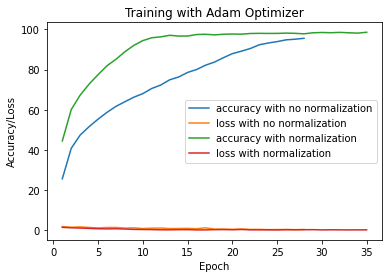

In [ ]:
# comparison: with adam, with or without normalization
plt.plot(np.arange(1, len(train_accuracies_SimpleConv_adam)+1), train_accuracies_SimpleConv_adam, label='accuracy with no normalization')
plt.plot(np.arange(1, len(train_losses_SimpleConv_adam)+1), train_losses_SimpleConv_adam, label='loss with no normalization')
plt.plot(np.arange(1, len(train_accuracies_SimpleConv2_adam)+1), train_accuracies_SimpleConv2_adam, label='accuracy with normalization')
plt.plot(np.arange(1, len(train_losses_SimpleConv2_adam)+1), train_losses_SimpleConv2_adam, label='loss with normalization')

plt.xlabel('Epoch')
plt.ylabel('Accuracy/Loss')
plt.legend()
plt.title('Training with Adam Optimizer')

#### Q2.6 d Once you choose an optimizer and see that it does train, make sure your model has enough capacity by overfitting on one batch of the data set. You should be able to get 100% train accuracy. 

As we see in Q2.6a, after epoch 15, the model attains 100% train accuracy.


### Q 2.7 Add residual connections

#### Residual connections help stabilise training and lead to faster convergence. In this question you will introduce residual connections into the SimpleConvnet2 model that you built above. 

We will add residual connections after each block of 3 convolutional layers. Lets consider the first block of three convolutional layers. The input to this block, the so called residual, is added to the output of the block before the final batch normalization layer of that block. 


IMP NOTE: You will notice that the number of filters of these two summands are not the same. For this, you will need to use a convolution layer on the residual component, which changes the number of filters while keeping the rest of the dimensions the same. This can be achieved with a careful selection of the input_channels, output_channels, kernel_size and padding parameters. 

In [21]:
class ResidualConvnet(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(ResidualConvnet, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channels, out_channels=64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),            
        )

        self.convBlock1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            # nn.BatchNorm2d(64),            
        )
        self.convBlock2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=9),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            # second residual
            # nn.BatchNorm2d(128),            
        )
        self.convBlock3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=9),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            # third residual
            # nn.BatchNorm2d(256),            
        )
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.batchnorm2 = nn.BatchNorm2d(128)
        self.batchnorm3 = nn.BatchNorm2d(256)
        
        self.maxpool1 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.maxpool3 = nn.MaxPool2d(kernel_size=32)
        self.linearproj = nn.Linear(256, num_classes)
        
        # TODO residual net
        self.residualConv2 = nn.Conv2d(in_channels=64,
                                       out_channels=128,
                                       kernel_size=3,
                                       padding=9     
        )
        self.residualConv3 = nn.Conv2d(in_channels=128,
                                       out_channels=256,
                                       kernel_size=3,
                                       padding=9     
        )

    def forward(self, x):
  
       # TODO
        # first residual, 64 channels, size = 32
        
        out = self.conv1(x)
        residual_1 = out
        # output, 64 channels, size = 32
        out = self.convBlock1(out)
        # add first residual
        out += residual_1
        # first batch norm
        out = self.batchnorm1(out)
        # first maxpool, size reduced to 16
        out = self.maxpool1(out)
        
        # second residual, 64 channels, size = 16
        residual_2 = out
        # make residual to 128 channels, size = 32
        residual_2 = self.residualConv2(residual_2)
        # output = 128 channels, size = 32
        out = self.convBlock2(out)
        # add second residual
        out += residual_2
        # second batchnorm
        out = self.batchnorm2(out)
        # second maxpool, size = 16
        out = self.maxpool2(out)

        # third residual, 128 channels, size = 16
        residual_3 = out

        # make residual to 256 channels, size = 32
        residual_3 = self.residualConv3(residual_3)
        out = self.convBlock3(out)
        # add third residual
        out += residual_3
        # third batch norm
        out = self.batchnorm3(out)
        # third maxpool
        out = self.maxpool3(out)
        out = out.view((-1,256))
        output = self.linearproj(out)
        return output
        

In [ ]:
# TODO : Initialize the model and cast to correct device
model_ResidualConvnet = ResidualConvnet(input_channels=3, num_classes=10)
model_ResidualConvnet.to(device)

# TODO : Initialize the criterion 
criterion = F.cross_entropy
# TODO : Initialize the optimizer 
optimizer = optim.SGD(model_ResidualConvnet.parameters(), lr=1e-3, momentum=0.5)
# TODO : Run the training loop using this model
train_losses_ResidualConvnet, train_accuracies_ResidualConvnet, \
  val_losses_ResidualConvnet, val_accuracies_ResidualConvnet = train_loop(model_ResidualConvnet, 
                                                                            criterion, optimizer, 
                                                                            train_loader, val_loader)

[EPOCH]: 0, [TRAIN LOSS]: 1.333888, [TRAIN ACCURACY]: 42.095
[EPOCH]: 0, [VAL LOSS]: 1.114968, [VAL ACCURACY]: 50.020 

[EPOCH]: 1, [TRAIN LOSS]: 1.082820, [TRAIN ACCURACY]: 57.278
[EPOCH]: 1, [VAL LOSS]: 1.108666, [VAL ACCURACY]: 56.430 

[EPOCH]: 2, [TRAIN LOSS]: 0.999872, [TRAIN ACCURACY]: 65.263
[EPOCH]: 2, [VAL LOSS]: 1.136297, [VAL ACCURACY]: 58.440 

[EPOCH]: 3, [TRAIN LOSS]: 1.138595, [TRAIN ACCURACY]: 70.918
[EPOCH]: 3, [VAL LOSS]: 0.842110, [VAL ACCURACY]: 59.620 

[EPOCH]: 4, [TRAIN LOSS]: 0.770641, [TRAIN ACCURACY]: 76.638
[EPOCH]: 4, [VAL LOSS]: 1.092945, [VAL ACCURACY]: 60.620 

[EPOCH]: 5, [TRAIN LOSS]: 0.591666, [TRAIN ACCURACY]: 81.940
[EPOCH]: 5, [VAL LOSS]: 1.189849, [VAL ACCURACY]: 60.390 

[EPOCH]: 6, [TRAIN LOSS]: 0.634848, [TRAIN ACCURACY]: 87.495
[EPOCH]: 6, [VAL LOSS]: 1.227938, [VAL ACCURACY]: 63.010 

[EPOCH]: 7, [TRAIN LOSS]: 0.422479, [TRAIN ACCURACY]: 92.475
[EPOCH]: 7, [VAL LOSS]: 1.265681, [VAL ACCURACY]: 61.620 

[EPOCH]: 8, [TRAIN LOSS]: 0.229447, [TRA

In [ ]:
save_model(model_name = 'ResidualConvnet', 
           model=model_ResidualConvnet, 
           train_losses=train_losses_ResidualConvnet, 
           train_accuracies=train_accuracies_ResidualConvnet, 
           val_losses=val_losses_ResidualConvnet, 
           val_accuracies=val_accuracies_ResidualConvnet)

Text(0.5, 1.0, 'Training for ResidualConvnet with Batch Normalization')

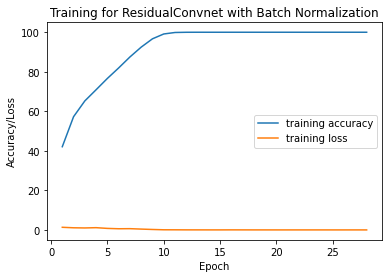

### Q 2.8 Plot the training curves with and without the residual connection. Comment on the difference. 

SimpleConvet2 with Residual Connection is able to saturate to 100% accuracy faster, in other words, it converges faster.

In [ ]:
with open('/content/drive/My Drive/model_SimpleConvnet2_2020-10-15 18:56:52.330137.txt', 'r') as file:
  content = file.readlines()
  print(content)
  train_accuracy_index = content.index('train_accuracies: \n')
  val_accuracy_index = content.index('val_accuracies: \n')
  
  train_accuracies_SimpleConv2 = [float(item[0:-5])for item in content[train_accuracy_index+1: val_accuracy_index-1]]
  print(train_accuracies_SimpleConv2)

Text(0.5, 1.0, 'Training for SimpleConvnet with Batch Normalization')

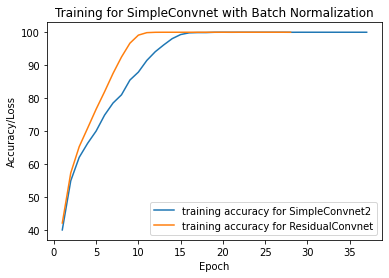

In [ ]:
# with Batch Normalization
# plot training loss vs epochs, training accuracy vs. epochs
plt.plot(np.arange(1, len(train_accuracies_SimpleConv2)+1), train_accuracies_SimpleConv2, label='training accuracy for SimpleConvnet2')
# plt.plot(np.arange(1, len(train_losses_SimpleConv2)+1), train_losses_SimpleConv2, label='training loss')
plt.plot(np.arange(1, len(train_accuracies_ResidualConvnet)+1), train_accuracies_ResidualConvnet, label='training accuracy for ResidualConvnet')

plt.xlabel('Epoch')
plt.ylabel('Accuracy/Loss')
plt.legend()
plt.title('Training for SimpleConvnet with Batch Normalization')

### Q2.9 Reducing overfiting 



In the previous questions, you might have observed that there is a large difference between the training and validation losses. This is a sign that the model is overfitting. One way to combat this is by adding random transformations to the input data to make your model more robust and prevent it from memorizing the input data. 

Torchvision provides several transforms that you can readily apply to your data. Experiment with adding a few transforms and report your results in terms of learning curves to see if the gap between the training and validation loss reduces and try to achieve better perfomance on the validation set. 

In [27]:
test_transform = transforms.Compose([
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         [0.4373, 0.4434, 0.4725],
                                         [0.1201, 0.1231, 0.1052])
                                     ])

train_transform = transforms.Compose([
                                      # TODO: Add more transforms here
                                      transforms.ColorJitter(contrast=7),
                                      transforms.RandomAffine(degrees=25,
                                                              scale=(0.8,1.2)), 
                                      transforms.ToTensor(),
                                      transforms.Normalize(
                                          [0.4373, 0.4434, 0.4725],
                                          [0.1201, 0.1231, 0.1052])
                                      ])


In [28]:
train_dataset_w_transform  = MapDataset(train_dataset, train_transform)
val_dataset_w_transform = MapDataset(val_dataset, test_transform)
test_dataset_w_transform = MapDataset(test_dataset, test_transform)

In [29]:
bs = 128
train_loader = DataLoader(train_dataset_w_transform, batch_size=bs, shuffle=True, drop_last=False)
val_loader = DataLoader(val_dataset_w_transform, batch_size=bs, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False, drop_last=False)

#### Use the residual network that you built above and use data augmentation to reduce the overfitting 

In [ ]:
# TODO : Initialize the model and cast to correct device
model_ResidualConvnet_transform = ResidualConvnet(input_channels=3, num_classes=10)
model_ResidualConvnet_transform.to(device)

# TODO : Initialize the criterion 
criterion = F.cross_entropy
# TODO : Initialize the optimizer 
optimizer = optim.SGD(model_ResidualConvnet_transform.parameters(), lr=1e-3, momentum=0.5)
# TODO : Run the training loop using this model
train_losses_ResidualConvnet_transform, \
train_accuracies_ResidualConvnet_transform, \
val_losses_ResidualConvnet_transform, \
val_accuracies_ResidualConvnet_transform = train_loop(
    model_ResidualConvnet_transform, 
    criterion, optimizer, 
    train_loader, val_loader)

[EPOCH]: 0, [TRAIN LOSS]: 1.661356, [TRAIN ACCURACY]: 30.343
[EPOCH]: 0, [VAL LOSS]: 1.376823, [VAL ACCURACY]: 32.470 

[EPOCH]: 1, [TRAIN LOSS]: 1.501770, [TRAIN ACCURACY]: 39.413
[EPOCH]: 1, [VAL LOSS]: 1.113628, [VAL ACCURACY]: 38.540 

[EPOCH]: 2, [TRAIN LOSS]: 1.398404, [TRAIN ACCURACY]: 43.123
[EPOCH]: 2, [VAL LOSS]: 0.981836, [VAL ACCURACY]: 45.830 

[EPOCH]: 3, [TRAIN LOSS]: 1.561306, [TRAIN ACCURACY]: 46.117
[EPOCH]: 3, [VAL LOSS]: 0.893973, [VAL ACCURACY]: 48.590 

[EPOCH]: 4, [TRAIN LOSS]: 1.340738, [TRAIN ACCURACY]: 48.235
[EPOCH]: 4, [VAL LOSS]: 0.988192, [VAL ACCURACY]: 49.070 

[EPOCH]: 5, [TRAIN LOSS]: 1.348339, [TRAIN ACCURACY]: 50.285
[EPOCH]: 5, [VAL LOSS]: 0.882998, [VAL ACCURACY]: 54.410 

[EPOCH]: 6, [TRAIN LOSS]: 1.400992, [TRAIN ACCURACY]: 51.760
[EPOCH]: 6, [VAL LOSS]: 0.835757, [VAL ACCURACY]: 54.560 

[EPOCH]: 7, [TRAIN LOSS]: 1.090388, [TRAIN ACCURACY]: 53.447
[EPOCH]: 7, [VAL LOSS]: 0.790034, [VAL ACCURACY]: 54.890 

[EPOCH]: 8, [TRAIN LOSS]: 1.239377, [TRA

In [ ]:
save_model(model_name='model_ResidualConvnet_transform', 
           model=model_ResidualConvnet_transform,
           train_losses=train_losses_ResidualConvnet_transform,
           train_accuracies=train_accuracies_ResidualConvnet_transform,
           val_losses=val_losses_ResidualConvnet_transform,
           val_accuracies=val_accuracies_ResidualConvnet_transform)

Text(0.5, 1.0, 'Training vs Validation Loss for ResidualConvnet')

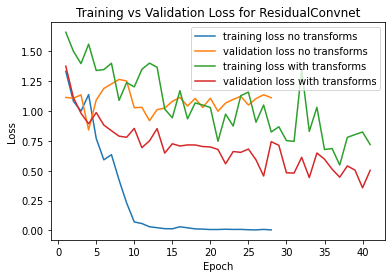

In [ ]:
plt.plot(np.arange(1, 
                   len(train_losses_ResidualConvnet)+1), 
         train_losses_ResidualConvnet, 
         label='training loss no transforms')
plt.plot(np.arange(1, 
                   len(val_losses_ResidualConvnet)+1), 
         val_losses_ResidualConvnet, 
         label='validation loss no transforms')
plt.plot(np.arange(1, 
                   len(train_losses_ResidualConvnet_transform)+1), 
         train_losses_ResidualConvnet_transform, 
         label='training loss with transforms')
plt.plot(np.arange(1, 
                   len(val_losses_ResidualConvnet_transform)+1), 
         val_losses_ResidualConvnet_transform, 
         label='validation loss with transforms')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss for ResidualConvnet')

As we can see below, a few observations can be made:
1. With the augmentation(additional transforms), the divergence between the training loss and the validation loss decreases;
2. The training loss decreases slower than the case where there is no augmentation, meaning it is harder for the model to learn.

### Q 2.10  Effect of learning rate decay 

#### Here you need to change the training loop to have one additional operation - add the scheduler step at the end of each epoch. Experiment with different learning rate schedulers provided by pytorch. Report results using atleast StepLR. 

In [30]:
from torch.optim.lr_scheduler import StepLR,ReduceLROnPlateau

In [31]:
def train_loop2(model, criterion, optimizer, scheduler,  train_loader, val_loader):
    """
    Generic training loop

    Parameters
    ----------
    model : Object instance of your model class 
    criterion : Loss function 
    optimizer : Instance of optimizer class of your choice 
    scheduler : Instance of scheduler class of your choice 
    train_loader : Training data loader 
    val_loader : Validation data loader

    Returns
    -------
    train_losses : List with train loss on dataset per epoch
    train_accuracies : List with train accuracy on dataset per epoch
    val_losses : List with validation loss on dataset per epoch
    val_accuracies : List with validation accuracy on dataset per epoch

    """
    best_val = 0.0
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    max_patience = 5
    patience_counter = 0
    # Training
    for t in tqdm(range(50)):
        # TODO : Set the model to train mode        
        model.train()
        train_correct = 0
        val_correct = 0
        # TODO: Loop over the training set 
        for batch_idx, (data, target) in enumerate(train_loader):
            # TODO: Put the inputs and targets on the write device
            data, target = data.to(device), target.to(device)
            # TODO: Feed forward to get the logits
            output = model(data)
            # TODO: Compute the loss and accuracy
            train_loss = criterion(output, target)
            train_pred = output.data.max(1, keepdim=True)[1]
            train_correct += train_pred.eq(target.data.view_as(train_pred)).cpu().sum().item()
            train_accuracy = 100. * train_correct/len(train_loader.dataset)
            # print('Training Accuracy: {}'.format(train_accuracy))
            # TODO: zero the gradients before running
            optimizer.zero_grad()
            # the backward pass.
            
            # TODO: Backward pass to compute the gradient
            # of loss w.r.t our learnable params. 
            train_loss.backward()
            # TODO: Update params
            optimizer.step()
            # TODO: Keep track of accuracy and loss
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        # TODO: Switch the model to eval mode
        model.eval()

        with torch.no_grad():
            # TODO: Loop over the validation set 
            for batch_idx, (data, target) in enumerate(val_loader):
                # TODO: Put the inputs and targets on the write device
                data, target = data.to(device), target.to(device)
                # TODO: Feed forward to get the logits
                output = model(data)
                # TODO: Compute the loss and accuracy
                val_loss = criterion(output, target)
                val_pred = output.data.max(1, keepdim=True)[1]
                val_correct += val_pred.eq(target.data.view_as(val_pred)).cpu().sum().item()
                val_accuracy = 100. * val_correct/len(val_loader.dataset)
                # print('Validation Accuracy: {}'.format(val_accuracy))
     
                # TODO: Keep track of accuracy and loss
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)              
        if val_accuracies[-1] > best_val:
          best_val = val_accuracies[-1]
          patience_counter = 0

          # TODO: Save best model, optimizer, epoch_number
          best_model = model
          best_optimizer = optimizer
          best_epoch_number = t
        else:
          patience_counter += 1    
          if patience_counter > max_patience: 
            break

        print("[EPOCH]: %i, [TRAIN LOSS]: %.6f, [TRAIN ACCURACY]: %.3f" % (t, train_losses[-1], train_accuracies[-1]))
        print("[EPOCH]: %i, [VAL LOSS]: %.6f, [VAL ACCURACY]: %.3f \n" % (t, val_losses[-1] ,val_accuracies[-1]))

        # scheduler step
        try:
          scheduler.step()
        except:
          scheduler.step(best_val)

    return train_losses, train_accuracies, val_losses, val_accuracies

In [ ]:
# TODO : Initialize the model and cast to correct device
model_ResidualConvnet_transform2 = ResidualConvnet(input_channels=3, num_classes=10)
model_ResidualConvnet_transform2.to(device)

# TODO : Initialize the criterion 
criterion = F.cross_entropy
# TODO : Initialize the optimizer 
optimizer = optim.SGD(model_ResidualConvnet_transform2.parameters(), lr=1e-3, momentum=0.5)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

# TODO : Run the training loop using this model
train_losses_ResidualConvnet_transform2, \
train_accuracies_ResidualConvnet_transform2, \
val_losses_ResidualConvnet_transform2, \
val_accuracies_ResidualConvnet_transform2 = train_loop2(
    model_ResidualConvnet_transform2, 
    criterion, optimizer, scheduler,
    train_loader, val_loader)

[EPOCH]: 0, [TRAIN LOSS]: 1.642019, [TRAIN ACCURACY]: 30.988
[EPOCH]: 0, [VAL LOSS]: 1.718121, [VAL ACCURACY]: 32.560 

[EPOCH]: 1, [TRAIN LOSS]: 1.748511, [TRAIN ACCURACY]: 39.560
[EPOCH]: 1, [VAL LOSS]: 1.327084, [VAL ACCURACY]: 42.820 

[EPOCH]: 2, [TRAIN LOSS]: 2.021510, [TRAIN ACCURACY]: 43.352
[EPOCH]: 2, [VAL LOSS]: 1.145162, [VAL ACCURACY]: 45.240 

[EPOCH]: 3, [TRAIN LOSS]: 1.473227, [TRAIN ACCURACY]: 45.447
[EPOCH]: 3, [VAL LOSS]: 1.053355, [VAL ACCURACY]: 49.090 

[EPOCH]: 4, [TRAIN LOSS]: 1.678883, [TRAIN ACCURACY]: 47.980
[EPOCH]: 4, [VAL LOSS]: 0.947910, [VAL ACCURACY]: 50.220 

[EPOCH]: 5, [TRAIN LOSS]: 1.520426, [TRAIN ACCURACY]: 49.953
[EPOCH]: 5, [VAL LOSS]: 1.007050, [VAL ACCURACY]: 50.430 

[EPOCH]: 6, [TRAIN LOSS]: 1.073523, [TRAIN ACCURACY]: 53.642
[EPOCH]: 6, [VAL LOSS]: 0.830469, [VAL ACCURACY]: 56.390 

[EPOCH]: 7, [TRAIN LOSS]: 1.094970, [TRAIN ACCURACY]: 54.050
[EPOCH]: 7, [VAL LOSS]: 0.808203, [VAL ACCURACY]: 56.520 

[EPOCH]: 8, [TRAIN LOSS]: 1.246493, [TRA

In [ ]:
save_model(model_name='model_ResidualConvnet_transform2', 
           model=model_ResidualConvnet_transform2,
           train_losses=train_losses_ResidualConvnet_transform2,
           train_accuracies=train_accuracies_ResidualConvnet_transform2,
           val_losses=val_losses_ResidualConvnet_transform2,
           val_accuracies=val_accuracies_ResidualConvnet_transform2)

Text(0.5, 1.0, 'Training/Validation Loss for ResidualConvnet')

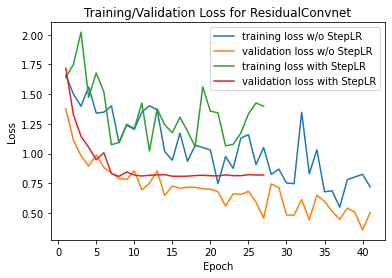

In [ ]:
plt.plot(np.arange(1, 
                   len(train_losses_ResidualConvnet_transform)+1), 
         train_losses_ResidualConvnet_transform, 
         label='training loss w/o StepLR')
plt.plot(np.arange(1, 
                   len(val_losses_ResidualConvnet_transform)+1), 
         val_losses_ResidualConvnet_transform, 
         label='validation loss w/o StepLR')

plt.plot(np.arange(1, 
                   len(train_losses_ResidualConvnet_transform2)+1), 
         train_losses_ResidualConvnet_transform2, 
         label='training loss with StepLR')
plt.plot(np.arange(1, 
                   len(val_losses_ResidualConvnet_transform2)+1), 
         val_losses_ResidualConvnet_transform2, 
         label='validation loss with StepLR')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training/Validation Loss for ResidualConvnet')

It looks the validation loss with StepLR is stuck at a local minimum.

In [ ]:
# TODO : Initialize the model and cast to correct device
model_ResidualConvnet_transform3 = ResidualConvnet(input_channels=3, num_classes=10)
model_ResidualConvnet_transform3.to(device)

# TODO : Initialize the criterion 
criterion = F.cross_entropy
# TODO : Initialize the optimizer 
optimizer = optim.SGD(model_ResidualConvnet_transform3.parameters(), lr=1e-3, momentum=0.5)
scheduler = ReduceLROnPlateau(optimizer, 'min')

# TODO : Run the training loop using this model
train_losses_ResidualConvnet_transform3, \
train_accuracies_ResidualConvnet_transform3, \
val_losses_ResidualConvnet_transform3, \
val_accuracies_ResidualConvnet_transform3 = train_loop2(
    model_ResidualConvnet_transform3, 
    criterion, optimizer, scheduler,
    train_loader, val_loader)

[EPOCH]: 0, [TRAIN LOSS]: 1.698005, [TRAIN ACCURACY]: 31.585
[EPOCH]: 0, [VAL LOSS]: 1.501793, [VAL ACCURACY]: 35.950 

[EPOCH]: 1, [TRAIN LOSS]: 1.751301, [TRAIN ACCURACY]: 39.962
[EPOCH]: 1, [VAL LOSS]: 1.309114, [VAL ACCURACY]: 40.650 

[EPOCH]: 2, [TRAIN LOSS]: 1.397159, [TRAIN ACCURACY]: 43.587
[EPOCH]: 2, [VAL LOSS]: 1.197346, [VAL ACCURACY]: 44.870 

[EPOCH]: 3, [TRAIN LOSS]: 1.580214, [TRAIN ACCURACY]: 46.325
[EPOCH]: 3, [VAL LOSS]: 1.017072, [VAL ACCURACY]: 48.970 

[EPOCH]: 4, [TRAIN LOSS]: 1.408910, [TRAIN ACCURACY]: 48.795
[EPOCH]: 4, [VAL LOSS]: 1.019376, [VAL ACCURACY]: 51.140 

[EPOCH]: 5, [TRAIN LOSS]: 1.484294, [TRAIN ACCURACY]: 50.392
[EPOCH]: 5, [VAL LOSS]: 0.939841, [VAL ACCURACY]: 52.290 

[EPOCH]: 6, [TRAIN LOSS]: 1.676404, [TRAIN ACCURACY]: 51.708
[EPOCH]: 6, [VAL LOSS]: 0.907791, [VAL ACCURACY]: 54.030 

[EPOCH]: 7, [TRAIN LOSS]: 1.172804, [TRAIN ACCURACY]: 53.195
[EPOCH]: 7, [VAL LOSS]: 0.944586, [VAL ACCURACY]: 55.650 

[EPOCH]: 8, [TRAIN LOSS]: 1.495758, [TRA

In [ ]:
save_model(model_name='model_ResidualConvnet_transform3', 
           model=model_ResidualConvnet_transform3,
           train_losses=train_losses_ResidualConvnet_transform3,
           train_accuracies=train_accuracies_ResidualConvnet_transform3,
           val_losses=val_losses_ResidualConvnet_transform3,
           val_accuracies=val_accuracies_ResidualConvnet_transform3)

Text(0.5, 1.0, 'Training/Validation Loss for ResidualConvnet')

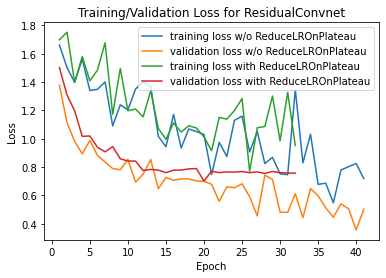

In [ ]:
plt.plot(np.arange(1, 
                   len(train_losses_ResidualConvnet_transform)+1), 
         train_losses_ResidualConvnet_transform, 
         label='training loss w/o ReduceLROnPlateau')
plt.plot(np.arange(1, 
                   len(val_losses_ResidualConvnet_transform)+1), 
         val_losses_ResidualConvnet_transform, 
         label='validation loss w/o ReduceLROnPlateau')

plt.plot(np.arange(1, 
                   len(train_losses_ResidualConvnet_transform3)+1), 
         train_losses_ResidualConvnet_transform3, 
         label='training loss with ReduceLROnPlateau')
plt.plot(np.arange(1, 
                   len(val_losses_ResidualConvnet_transform3)+1), 
         val_losses_ResidualConvnet_transform3, 
         label='validation loss with ReduceLROnPlateau')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training/Validation Loss for ResidualConvnet')

### Q2.11 Hyper parameter tuning 


#### Experiment with a range of learning rates and optimizers, as well as the parameter in the learning rate scheduler for StepLR. Report the following plots: 

1. Learning curves (training and validation loss for 5 different learning rate with SGD optimizer)
Best: learning rate = 0.1, Val Accuracy = 83.230%;
2. Learning curves (training and validation loss for 5 different learning rate with Adam optimizer)
Best: learning rate = 0.001, Val Accuracy = 87%
3. Learning curves (training and validation loss for 5 different gamma parameter for the StepLR)





In [18]:
# SGD optimizer
learning_rates=[1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
for i in range(len(learning_rates)):
  learning_rate = learning_rates[i]
  print('Learning Rate: ', learning_rate)
  model_ResidualConvnet_transform = ResidualConvnet(input_channels=3, num_classes=10)
  model_ResidualConvnet_transform.to(device)

  # TODO : Initialize the criterion 
  criterion = F.cross_entropy
  # TODO : Initialize the optimizer 
  optimizer = optim.SGD(model_ResidualConvnet_transform.parameters(), 
                        lr=learning_rate, momentum=0.5)
  # TODO : Run the training loop using this model
  train_losses_ResidualConvnet_transform, \
  train_accuracies_ResidualConvnet_transform, \
  val_losses_ResidualConvnet_transform, \
  val_accuracies_ResidualConvnet_transform = train_loop(
      model_ResidualConvnet_transform, 
      criterion, optimizer, 
      train_loader, val_loader)
  
  # save model
  save_model(model_name='model_ResidualConvnet_transform_grid_search_sgd_{}'.format(i), 
           model=model_ResidualConvnet_transform,
           train_losses=train_losses_ResidualConvnet_transform,
           train_accuracies=train_accuracies_ResidualConvnet_transform,
           val_losses=val_losses_ResidualConvnet_transform,
           val_accuracies=val_accuracies_ResidualConvnet_transform)

Learning Rate:  0.01


[EPOCH]: 0, [TRAIN LOSS]: 2.077592, [TRAIN ACCURACY]: 24.852
[EPOCH]: 0, [VAL LOSS]: 2.052994, [VAL ACCURACY]: 27.770 

[EPOCH]: 1, [TRAIN LOSS]: 1.888456, [TRAIN ACCURACY]: 35.432
[EPOCH]: 1, [VAL LOSS]: 1.633260, [VAL ACCURACY]: 29.800 

[EPOCH]: 2, [TRAIN LOSS]: 1.296241, [TRAIN ACCURACY]: 40.992
[EPOCH]: 2, [VAL LOSS]: 1.020644, [VAL ACCURACY]: 46.900 

[EPOCH]: 3, [TRAIN LOSS]: 1.416716, [TRAIN ACCURACY]: 45.140
[EPOCH]: 3, [VAL LOSS]: 1.294842, [VAL ACCURACY]: 47.820 

[EPOCH]: 4, [TRAIN LOSS]: 1.573359, [TRAIN ACCURACY]: 48.635
[EPOCH]: 4, [VAL LOSS]: 1.078904, [VAL ACCURACY]: 54.710 

[EPOCH]: 5, [TRAIN LOSS]: 1.055273, [TRAIN ACCURACY]: 51.803
[EPOCH]: 5, [VAL LOSS]: 1.154445, [VAL ACCURACY]: 55.780 

[EPOCH]: 6, [TRAIN LOSS]: 1.342559, [TRAIN ACCURACY]: 54.850
[EPOCH]: 6, [VAL LOSS]: 1.183374, [VAL ACCURACY]: 56.410 

[EPOCH]: 7, [TRAIN LOSS]: 1.294664, [TRAIN ACCURACY]: 56.913
[EPOCH]: 7, [VAL LOSS]: 0.747565, [VAL ACCURACY]: 61.360 

[EPOCH]: 8, [TRAIN LOSS]: 1.076672, [TRA

[EPOCH]: 0, [TRAIN LOSS]: 1.800180, [TRAIN ACCURACY]: 30.180
[EPOCH]: 0, [VAL LOSS]: 1.324386, [VAL ACCURACY]: 36.470 

[EPOCH]: 1, [TRAIN LOSS]: 1.752386, [TRAIN ACCURACY]: 39.562
[EPOCH]: 1, [VAL LOSS]: 1.182052, [VAL ACCURACY]: 40.260 

[EPOCH]: 2, [TRAIN LOSS]: 1.559772, [TRAIN ACCURACY]: 43.447
[EPOCH]: 2, [VAL LOSS]: 1.130344, [VAL ACCURACY]: 45.550 

[EPOCH]: 3, [TRAIN LOSS]: 1.550982, [TRAIN ACCURACY]: 46.250
[EPOCH]: 3, [VAL LOSS]: 1.028252, [VAL ACCURACY]: 48.250 

[EPOCH]: 4, [TRAIN LOSS]: 1.654561, [TRAIN ACCURACY]: 48.860
[EPOCH]: 4, [VAL LOSS]: 0.974879, [VAL ACCURACY]: 50.760 

[EPOCH]: 5, [TRAIN LOSS]: 1.426551, [TRAIN ACCURACY]: 50.242
[EPOCH]: 5, [VAL LOSS]: 1.008338, [VAL ACCURACY]: 53.250 

[EPOCH]: 6, [TRAIN LOSS]: 1.172141, [TRAIN ACCURACY]: 52.175
[EPOCH]: 6, [VAL LOSS]: 0.932015, [VAL ACCURACY]: 56.380 

[EPOCH]: 7, [TRAIN LOSS]: 1.176677, [TRAIN ACCURACY]: 53.055
[EPOCH]: 7, [VAL LOSS]: 1.088756, [VAL ACCURACY]: 54.180 

[EPOCH]: 8, [TRAIN LOSS]: 1.473705, [TRA

[EPOCH]: 0, [TRAIN LOSS]: 2.010375, [TRAIN ACCURACY]: 21.420
[EPOCH]: 0, [VAL LOSS]: 1.841825, [VAL ACCURACY]: 23.200 

[EPOCH]: 1, [TRAIN LOSS]: 2.029279, [TRAIN ACCURACY]: 28.870
[EPOCH]: 1, [VAL LOSS]: 1.692052, [VAL ACCURACY]: 26.970 

[EPOCH]: 2, [TRAIN LOSS]: 1.936961, [TRAIN ACCURACY]: 31.823
[EPOCH]: 2, [VAL LOSS]: 1.612127, [VAL ACCURACY]: 30.150 

[EPOCH]: 3, [TRAIN LOSS]: 1.732206, [TRAIN ACCURACY]: 34.040
[EPOCH]: 3, [VAL LOSS]: 1.523979, [VAL ACCURACY]: 32.220 

[EPOCH]: 4, [TRAIN LOSS]: 1.779820, [TRAIN ACCURACY]: 36.300
[EPOCH]: 4, [VAL LOSS]: 1.491806, [VAL ACCURACY]: 33.930 

[EPOCH]: 5, [TRAIN LOSS]: 1.860926, [TRAIN ACCURACY]: 37.375
[EPOCH]: 5, [VAL LOSS]: 1.396686, [VAL ACCURACY]: 35.080 

[EPOCH]: 6, [TRAIN LOSS]: 1.938209, [TRAIN ACCURACY]: 38.235
[EPOCH]: 6, [VAL LOSS]: 1.376057, [VAL ACCURACY]: 36.550 

[EPOCH]: 7, [TRAIN LOSS]: 1.613790, [TRAIN ACCURACY]: 39.367
[EPOCH]: 7, [VAL LOSS]: 1.325261, [VAL ACCURACY]: 38.290 

[EPOCH]: 8, [TRAIN LOSS]: 1.581138, [TRA

[EPOCH]: 0, [TRAIN LOSS]: 2.296459, [TRAIN ACCURACY]: 13.443
[EPOCH]: 0, [VAL LOSS]: 2.193326, [VAL ACCURACY]: 14.190 

[EPOCH]: 1, [TRAIN LOSS]: 2.342474, [TRAIN ACCURACY]: 17.150
[EPOCH]: 1, [VAL LOSS]: 2.138245, [VAL ACCURACY]: 16.560 

[EPOCH]: 2, [TRAIN LOSS]: 2.104625, [TRAIN ACCURACY]: 19.100
[EPOCH]: 2, [VAL LOSS]: 2.096400, [VAL ACCURACY]: 17.810 

[EPOCH]: 3, [TRAIN LOSS]: 2.062196, [TRAIN ACCURACY]: 20.508
[EPOCH]: 3, [VAL LOSS]: 2.021443, [VAL ACCURACY]: 18.640 

[EPOCH]: 4, [TRAIN LOSS]: 2.215405, [TRAIN ACCURACY]: 21.988
[EPOCH]: 4, [VAL LOSS]: 2.019474, [VAL ACCURACY]: 19.340 

[EPOCH]: 5, [TRAIN LOSS]: 2.136320, [TRAIN ACCURACY]: 23.078
[EPOCH]: 5, [VAL LOSS]: 2.009875, [VAL ACCURACY]: 20.150 

[EPOCH]: 6, [TRAIN LOSS]: 2.188229, [TRAIN ACCURACY]: 23.918
[EPOCH]: 6, [VAL LOSS]: 1.963972, [VAL ACCURACY]: 20.710 

[EPOCH]: 7, [TRAIN LOSS]: 2.288743, [TRAIN ACCURACY]: 24.367
[EPOCH]: 7, [VAL LOSS]: 1.945325, [VAL ACCURACY]: 21.130 

[EPOCH]: 8, [TRAIN LOSS]: 2.014276, [TRA

[EPOCH]: 0, [TRAIN LOSS]: 3.390056, [TRAIN ACCURACY]: 10.557
[EPOCH]: 0, [VAL LOSS]: 3.169410, [VAL ACCURACY]: 10.800 

[EPOCH]: 1, [TRAIN LOSS]: 2.939651, [TRAIN ACCURACY]: 10.680
[EPOCH]: 1, [VAL LOSS]: 2.817504, [VAL ACCURACY]: 11.350 

[EPOCH]: 2, [TRAIN LOSS]: 2.573390, [TRAIN ACCURACY]: 10.955
[EPOCH]: 2, [VAL LOSS]: 2.638889, [VAL ACCURACY]: 12.000 

[EPOCH]: 3, [TRAIN LOSS]: 2.475435, [TRAIN ACCURACY]: 11.890
[EPOCH]: 3, [VAL LOSS]: 2.577849, [VAL ACCURACY]: 12.750 

[EPOCH]: 4, [TRAIN LOSS]: 2.537523, [TRAIN ACCURACY]: 12.465
[EPOCH]: 4, [VAL LOSS]: 2.532356, [VAL ACCURACY]: 13.240 

[EPOCH]: 5, [TRAIN LOSS]: 2.411770, [TRAIN ACCURACY]: 12.883
[EPOCH]: 5, [VAL LOSS]: 2.531045, [VAL ACCURACY]: 13.720 

[EPOCH]: 6, [TRAIN LOSS]: 2.324500, [TRAIN ACCURACY]: 13.700
[EPOCH]: 6, [VAL LOSS]: 2.477103, [VAL ACCURACY]: 14.470 

[EPOCH]: 7, [TRAIN LOSS]: 2.428150, [TRAIN ACCURACY]: 14.008
[EPOCH]: 7, [VAL LOSS]: 2.439952, [VAL ACCURACY]: 14.840 

[EPOCH]: 8, [TRAIN LOSS]: 2.477445, [TRA

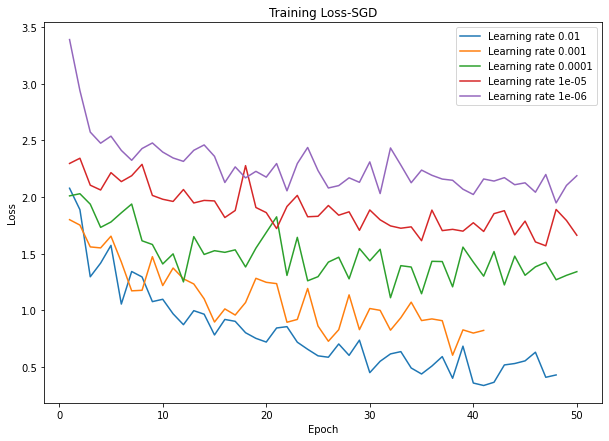

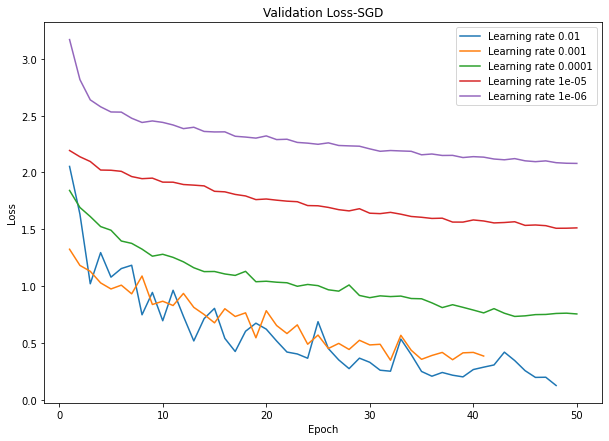

In [66]:
# Training and Validation Loss for Grid search with SGD
def read_records(model_name, date):
  train_losses_list = []
  val_losses_list = []
  for i in range(5):
    record_name = ''
    record_name = model_name + '_{}_'.format(i) + date + '.txt'
    path = '/content/drive/My Drive/'
    with open(path+record_name, 'r') as file:
      content = file.readlines()
      train_accuracy_index = content.index('train_accuracies: \n')
      val_accuracy_index = content.index('val_accuracies: \n')
      train_loss_index = content.index('train_losses: \n')
      val_loss_index = content.index('val_losses: \n')
      train_loss = [float(item[7:13]) for item in content[train_loss_index+1: val_accuracy_index-1]]
      val_loss = [float(item[7:13]) for item in content[val_loss_index+1:-1]]
      train_losses_list.append(train_loss)
      val_losses_list.append(val_loss)
  return train_losses_list, val_losses_list
train_losses_list, val_losses_list = read_records(
    'model_ResidualConvnet_transform_grid_search_sgd',
    '2020-10-16 05:33:02.814820')


# learning rate
learning_rates=[1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
fig, ax = plt.subplots(figsize = (10,7))
for i in range(len(learning_rates)):
  y = train_losses_list[i]
  x = range(1, len(y)+1)
  ax.plot(x, y, label = 'Learning rate {}'.format(learning_rates[i]))
  plt.legend()
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training Loss-SGD')

fig2, ax2 = plt.subplots(figsize = (10,7))
for i in range(len(learning_rates)):
  y = val_losses_list[i]
  x = range(1, len(y)+1)
  ax2.plot(x, y, label = 'Learning rate {}'.format(learning_rates[i]))
  plt.legend()
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Validation Loss-SGD')

In [32]:
# Adam Optimizer
learning_rates=[1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
for i in range(len(learning_rates)):
  learning_rate = learning_rates[i]
  print('Learning Rate: ', learning_rate)
  model_ResidualConvnet_transform = ResidualConvnet(input_channels=3, num_classes=10)
  model_ResidualConvnet_transform.to(device)

  # TODO : Initialize the criterion 
  criterion = F.cross_entropy
  # TODO : Initialize the optimizer 
  optimizer = optim.Adam(model_ResidualConvnet_transform.parameters(), lr=learning_rate)
  # TODO : Run the training loop using this model
  train_losses_ResidualConvnet_transform, \
  train_accuracies_ResidualConvnet_transform, \
  val_losses_ResidualConvnet_transform, \
  val_accuracies_ResidualConvnet_transform = train_loop(
      model_ResidualConvnet_transform, 
      criterion, optimizer, 
      train_loader, val_loader)
  
  # save model
  save_model(model_name='model_ResidualConvnet_transform_grid_search_adam_{}'.format(i), 
           model=model_ResidualConvnet_transform,
           train_losses=train_losses_ResidualConvnet_transform,
           train_accuracies=train_accuracies_ResidualConvnet_transform,
           val_losses=val_losses_ResidualConvnet_transform,
           val_accuracies=val_accuracies_ResidualConvnet_transform)

Learning Rate:  0.01


[EPOCH]: 0, [TRAIN LOSS]: 1.729016, [TRAIN ACCURACY]: 20.670
[EPOCH]: 0, [VAL LOSS]: 2.080158, [VAL ACCURACY]: 28.610 

[EPOCH]: 1, [TRAIN LOSS]: 1.814264, [TRAIN ACCURACY]: 33.260
[EPOCH]: 1, [VAL LOSS]: 1.368047, [VAL ACCURACY]: 37.640 

[EPOCH]: 2, [TRAIN LOSS]: 1.426026, [TRAIN ACCURACY]: 39.013
[EPOCH]: 2, [VAL LOSS]: 1.204288, [VAL ACCURACY]: 46.450 

[EPOCH]: 3, [TRAIN LOSS]: 1.378200, [TRAIN ACCURACY]: 43.970
[EPOCH]: 3, [VAL LOSS]: 1.272758, [VAL ACCURACY]: 48.560 

[EPOCH]: 4, [TRAIN LOSS]: 1.460799, [TRAIN ACCURACY]: 48.157
[EPOCH]: 4, [VAL LOSS]: 1.056827, [VAL ACCURACY]: 56.260 

[EPOCH]: 5, [TRAIN LOSS]: 1.256391, [TRAIN ACCURACY]: 51.725
[EPOCH]: 5, [VAL LOSS]: 0.919673, [VAL ACCURACY]: 58.060 

[EPOCH]: 6, [TRAIN LOSS]: 1.286133, [TRAIN ACCURACY]: 54.990
[EPOCH]: 6, [VAL LOSS]: 0.826001, [VAL ACCURACY]: 60.560 

[EPOCH]: 7, [TRAIN LOSS]: 1.129115, [TRAIN ACCURACY]: 57.840
[EPOCH]: 7, [VAL LOSS]: 0.815170, [VAL ACCURACY]: 65.660 

[EPOCH]: 8, [TRAIN LOSS]: 1.199342, [TRA

[EPOCH]: 0, [TRAIN LOSS]: 1.622423, [TRAIN ACCURACY]: 33.005
[EPOCH]: 0, [VAL LOSS]: 1.355818, [VAL ACCURACY]: 44.040 

[EPOCH]: 1, [TRAIN LOSS]: 1.416420, [TRAIN ACCURACY]: 47.085
[EPOCH]: 1, [VAL LOSS]: 0.979380, [VAL ACCURACY]: 55.780 

[EPOCH]: 2, [TRAIN LOSS]: 1.373294, [TRAIN ACCURACY]: 54.328
[EPOCH]: 2, [VAL LOSS]: 1.007066, [VAL ACCURACY]: 64.140 

[EPOCH]: 3, [TRAIN LOSS]: 1.184072, [TRAIN ACCURACY]: 60.002
[EPOCH]: 3, [VAL LOSS]: 1.039011, [VAL ACCURACY]: 66.790 

[EPOCH]: 4, [TRAIN LOSS]: 1.078235, [TRAIN ACCURACY]: 64.155
[EPOCH]: 4, [VAL LOSS]: 0.752745, [VAL ACCURACY]: 73.540 

[EPOCH]: 5, [TRAIN LOSS]: 1.071026, [TRAIN ACCURACY]: 66.645
[EPOCH]: 5, [VAL LOSS]: 0.488882, [VAL ACCURACY]: 76.090 

[EPOCH]: 6, [TRAIN LOSS]: 0.909369, [TRAIN ACCURACY]: 68.823
[EPOCH]: 6, [VAL LOSS]: 0.459402, [VAL ACCURACY]: 77.930 

[EPOCH]: 7, [TRAIN LOSS]: 0.914336, [TRAIN ACCURACY]: 70.940
[EPOCH]: 7, [VAL LOSS]: 0.525032, [VAL ACCURACY]: 78.270 

[EPOCH]: 8, [TRAIN LOSS]: 0.737279, [TRA

[EPOCH]: 0, [TRAIN LOSS]: 1.646358, [TRAIN ACCURACY]: 35.870
[EPOCH]: 0, [VAL LOSS]: 1.300440, [VAL ACCURACY]: 43.390 

[EPOCH]: 1, [TRAIN LOSS]: 1.439219, [TRAIN ACCURACY]: 46.180
[EPOCH]: 1, [VAL LOSS]: 1.057655, [VAL ACCURACY]: 54.460 

[EPOCH]: 2, [TRAIN LOSS]: 1.332832, [TRAIN ACCURACY]: 51.428
[EPOCH]: 2, [VAL LOSS]: 0.755213, [VAL ACCURACY]: 56.130 

[EPOCH]: 3, [TRAIN LOSS]: 1.320378, [TRAIN ACCURACY]: 55.178
[EPOCH]: 3, [VAL LOSS]: 0.891085, [VAL ACCURACY]: 62.320 

[EPOCH]: 4, [TRAIN LOSS]: 1.127027, [TRAIN ACCURACY]: 57.943
[EPOCH]: 4, [VAL LOSS]: 0.733383, [VAL ACCURACY]: 65.090 

[EPOCH]: 5, [TRAIN LOSS]: 0.950558, [TRAIN ACCURACY]: 60.585
[EPOCH]: 5, [VAL LOSS]: 0.712512, [VAL ACCURACY]: 67.820 

[EPOCH]: 6, [TRAIN LOSS]: 1.072785, [TRAIN ACCURACY]: 63.050
[EPOCH]: 6, [VAL LOSS]: 0.710056, [VAL ACCURACY]: 68.550 

[EPOCH]: 7, [TRAIN LOSS]: 0.911283, [TRAIN ACCURACY]: 64.757
[EPOCH]: 7, [VAL LOSS]: 0.512206, [VAL ACCURACY]: 70.940 

[EPOCH]: 8, [TRAIN LOSS]: 0.805554, [TRA

[EPOCH]: 0, [TRAIN LOSS]: 1.843105, [TRAIN ACCURACY]: 24.740
[EPOCH]: 0, [VAL LOSS]: 1.702389, [VAL ACCURACY]: 28.200 

[EPOCH]: 1, [TRAIN LOSS]: 1.868273, [TRAIN ACCURACY]: 33.767
[EPOCH]: 1, [VAL LOSS]: 1.533992, [VAL ACCURACY]: 33.350 

[EPOCH]: 2, [TRAIN LOSS]: 1.658339, [TRAIN ACCURACY]: 37.340
[EPOCH]: 2, [VAL LOSS]: 1.394186, [VAL ACCURACY]: 37.360 

[EPOCH]: 3, [TRAIN LOSS]: 1.333923, [TRAIN ACCURACY]: 40.440
[EPOCH]: 3, [VAL LOSS]: 1.298613, [VAL ACCURACY]: 40.460 

[EPOCH]: 4, [TRAIN LOSS]: 1.558561, [TRAIN ACCURACY]: 42.320
[EPOCH]: 4, [VAL LOSS]: 1.205520, [VAL ACCURACY]: 42.140 

[EPOCH]: 5, [TRAIN LOSS]: 1.610898, [TRAIN ACCURACY]: 44.770
[EPOCH]: 5, [VAL LOSS]: 1.091480, [VAL ACCURACY]: 44.190 

[EPOCH]: 6, [TRAIN LOSS]: 1.649071, [TRAIN ACCURACY]: 45.205
[EPOCH]: 6, [VAL LOSS]: 1.079089, [VAL ACCURACY]: 46.790 

[EPOCH]: 7, [TRAIN LOSS]: 1.316306, [TRAIN ACCURACY]: 46.767
[EPOCH]: 7, [VAL LOSS]: 1.081721, [VAL ACCURACY]: 48.850 

[EPOCH]: 8, [TRAIN LOSS]: 1.604107, [TRA

[EPOCH]: 0, [TRAIN LOSS]: 2.647631, [TRAIN ACCURACY]: 10.623
[EPOCH]: 0, [VAL LOSS]: 3.184857, [VAL ACCURACY]: 11.970 

[EPOCH]: 1, [TRAIN LOSS]: 2.225793, [TRAIN ACCURACY]: 17.200
[EPOCH]: 1, [VAL LOSS]: 2.127570, [VAL ACCURACY]: 17.490 

[EPOCH]: 2, [TRAIN LOSS]: 2.055097, [TRAIN ACCURACY]: 21.005
[EPOCH]: 2, [VAL LOSS]: 1.916412, [VAL ACCURACY]: 20.540 

[EPOCH]: 3, [TRAIN LOSS]: 2.128349, [TRAIN ACCURACY]: 23.810
[EPOCH]: 3, [VAL LOSS]: 1.832090, [VAL ACCURACY]: 22.120 

[EPOCH]: 4, [TRAIN LOSS]: 2.029351, [TRAIN ACCURACY]: 25.598
[EPOCH]: 4, [VAL LOSS]: 1.749277, [VAL ACCURACY]: 23.760 

[EPOCH]: 5, [TRAIN LOSS]: 2.124226, [TRAIN ACCURACY]: 27.155
[EPOCH]: 5, [VAL LOSS]: 1.693484, [VAL ACCURACY]: 24.220 

[EPOCH]: 6, [TRAIN LOSS]: 1.937455, [TRAIN ACCURACY]: 28.343
[EPOCH]: 6, [VAL LOSS]: 1.663162, [VAL ACCURACY]: 25.310 

[EPOCH]: 7, [TRAIN LOSS]: 1.935532, [TRAIN ACCURACY]: 29.940
[EPOCH]: 7, [VAL LOSS]: 1.638762, [VAL ACCURACY]: 26.210 

[EPOCH]: 8, [TRAIN LOSS]: 1.882731, [TRA

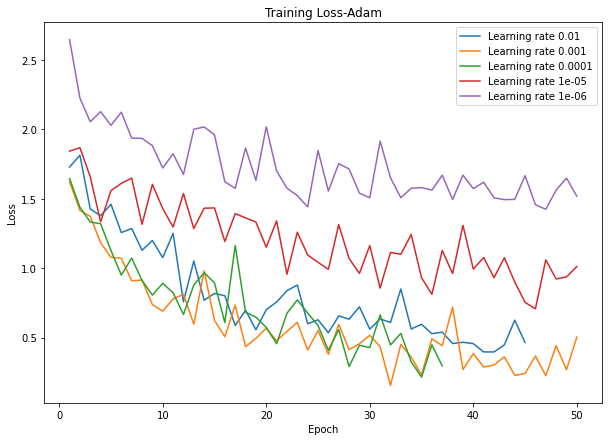

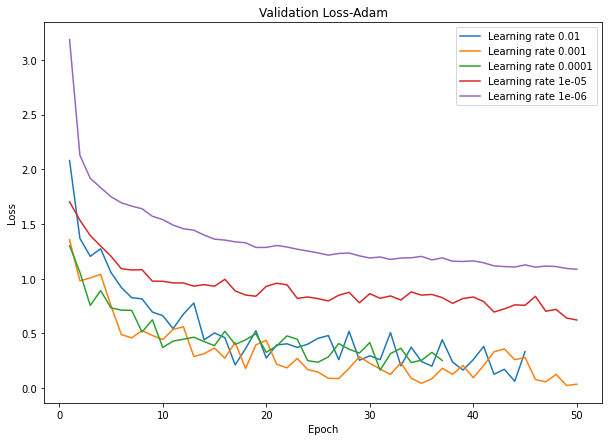

In [65]:
train_losses_list, val_losses_list = read_records(
    'model_ResidualConvnet_transform_grid_search_adam',
    '2020-10-16 14:06:40.518999')
learning_rates=[1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
fig, ax = plt.subplots(figsize = (10,7))
for i in range(len(learning_rates)):
  y = train_losses_list[i]
  x = range(1, len(y)+1)
  ax.plot(x, y, label = 'Learning rate {}'.format(learning_rates[i]))
  plt.legend()
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training Loss-Adam')

fig2, ax2 = plt.subplots(figsize = (10,7))
for i in range(len(learning_rates)):
  y = val_losses_list[i]
  x = range(1, len(y)+1)
  ax2.plot(x, y, label = 'Learning rate {}'.format(learning_rates[i]))
  plt.legend()
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Validation Loss-Adam')


In [33]:
# StepLR
gamma_parameters=[1e-1, 1e-2, 1e-3, 1e-4, 1e-5]

for i in range(len(gamma_parameters)):
  gamma_rate = gamma_parameters[i]
  print('Gamma Rate: ', gamma_rate)
  model_ResidualConvnet_transform3 = ResidualConvnet(input_channels=3, num_classes=10)
  model_ResidualConvnet_transform3.to(device)

  # TODO : Initialize the criterion 
  criterion = F.cross_entropy
  # TODO : Initialize the optimizer 
  optimizer = optim.SGD(model_ResidualConvnet_transform3.parameters(), lr=1e-3, momentum=0.5)
  scheduler = StepLR(optimizer, step_size=6, gamma=gamma_rate)

  # TODO : Run the training loop using this model
  train_losses_ResidualConvnet_transform3, \
  train_accuracies_ResidualConvnet_transform3, \
  val_losses_ResidualConvnet_transform3, \
  val_accuracies_ResidualConvnet_transform3 = train_loop2(
      model_ResidualConvnet_transform3, 
      criterion, optimizer, scheduler,
      train_loader, val_loader)
  
  # save model
  save_model(model_name='model_ResidualConvnet_transform_grid_search_steplr_{}'.format(i), 
           model=model_ResidualConvnet_transform3,
           train_losses=train_losses_ResidualConvnet_transform3,
           train_accuracies=train_accuracies_ResidualConvnet_transform3,
           val_losses=val_losses_ResidualConvnet_transform3,
           val_accuracies=val_accuracies_ResidualConvnet_transform3)  


Gamma Rate:  0.1


KeyboardInterrupt: ignored

In [ ]:
# # 

### Q2.12 Load the model that gave you best validation accuracy and report results on the test set. 

In [ ]:
d